In [487]:
import zarr
from buffer.frame_buffer import ReplayBuffer
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import math

def rotate_origin_only(x, y, radians):
    """Only rotate a point around the origin (0, 0)."""
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

In [488]:
replay_buffer = ReplayBuffer(int(2e3), history_size=1, dshape=(160, 384, 3), dtype=torch.uint8, goal_size=3)
replay_buffer.load(Path('/Users/nimit/Documents/robomaster/habitat/160x384'))
# zarr.load('/Users/nimit/Documents/robomaster/habitat/160x384', mode='r')

[!] loaded buffer


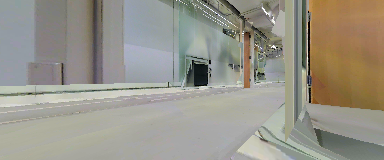

In [489]:
i = 95
Image.fromarray(replay_buffer.targets[i].squeeze().numpy())

# Compass

In [743]:
r, t = torch.tensor([[ 9.7390, -2.6678],
        [ 9.7390, -2.4932],
        [ 9.7390, -2.3187],
        [ 9.7390, -2.1442],
        [ 9.7390, -1.9696],
        [ 9.7390, -1.7951],
        [ 9.7390, -1.6206],
        [ 9.7390, -1.4460],
        [ 9.7390, -1.2715],
        [ 9.7390, -1.0970],
        [ 9.7390, -0.9224],
        [ 9.5901, -0.9432],
        [ 9.4455, -0.9646],
        [ 9.4455, -0.7901],
        [ 9.2712, -0.8093],
        [ 9.1005, -0.8291],
        [ 8.9335, -0.8498],
        [ 8.7705, -0.8712],
        [ 8.7705, -0.6967],
        [ 8.5802, -0.7153],
        [ 8.3931, -0.7349],
        [ 8.2094, -0.7553],
        [ 8.0292, -0.7767],
        [ 8.0292, -0.6021],
        [ 7.8244, -0.6202],
        [ 7.8244, -0.4457],
        [ 7.5996, -0.4599],
        [ 7.3764, -0.4749],
        [ 7.3764, -0.3004],
        [ 7.1380, -0.3107],
        [ 6.9004, -0.3218],
        [ 6.6637, -0.3337],
        [ 6.4280, -0.3464],
        [ 6.1934, -0.3601],
        [ 6.1934, -0.1856],
        [ 5.9479, -0.1934],
        [ 5.7028, -0.2018],
        [ 5.4581, -0.2110],
        [ 5.2139, -0.2210],
        [ 4.9703, -0.2320],
        [ 4.7273, -0.2442],
        [ 4.4851, -0.2577],
        [ 4.2439, -0.2727],
        [ 4.2439, -0.0981],
        [ 3.9951, -0.1043],
        [ 3.7466, -0.1112],
        [ 3.7466,  0.0633],
        [ 3.4971,  0.0678],
        [ 3.2477,  0.0731],
        [ 2.9985,  0.0792],
        [ 2.7493,  0.0863],
        [ 2.5003,  0.0950],
        [ 2.2516,  0.1055],
        [ 2.0032,  0.1186],
        [ 1.7552,  0.1355],
        [ 1.5078,  0.1579],
        [ 1.5078, -0.0166],
        [ 1.2579, -0.0200],
        [ 1.0079, -0.0249],
        [ 0.7580, -0.0331],
        [ 0.7580, -0.2076],
        [ 0.7580, -0.3822],
        [ 0.5438, -0.5725],
        [ 0.5438, -0.7470],
        [ 0.3984, -1.1875],
        [ 0.3984, -1.0130],
        [ 0.3984, -0.8384],
        [ 0.3984, -0.6639],
        [ 0.3984, -0.4894],
        [ 0.3984, -0.3148],
        [ 0.3984, -0.1403],
        [ 0.1549, -0.3680]]).T

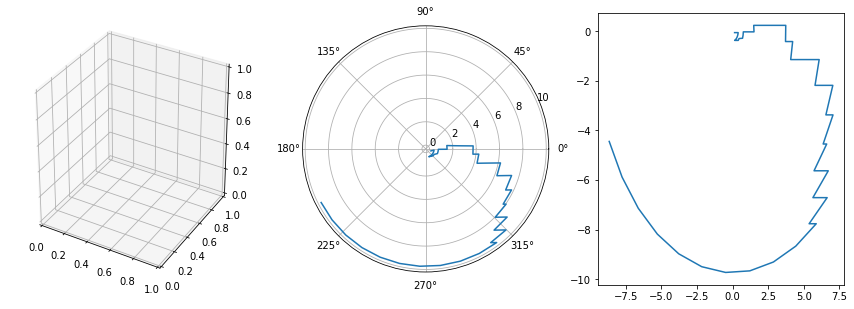

In [744]:
# 0 -> 140
# 140 -> 269
# 269 -> 431
# r, c, s = replay_buffer.goals.T

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131, projection='3d')
# ax1.scatter(c, s, r, c='r', marker='o')

ax2 = fig.add_subplot(132, projection='polar')
# t = np.arccos(c)
ax2.plot(t, r)

ax3 = fig.add_subplot(133)
ax3.plot(r*np.cos(t), r*np.sin(t))

In [962]:
def get_arc(actions, i, j):
    movement = actions[i:i+50] == 1
    k = np.searchsorted(np.cumsum(movement), j).item()

    R = r[i:i+k][movement[:k]]-r[i] # relative
    T = t[i:i+k][movement[:k]]-t[i+1] # absolute
    x, y = rotate_origin_only(R*np.cos(T), R*np.sin(T), np.pi/2)
    if T.shape[0] > 1 and (y < 0).sum() == 0: # if behind camera, then use prev
        _t = np.linspace(T[0], T[-1], 10)
        _r = np.linspace(R[0], R[-1], 10)
        print(R[-1], T[-1])
        _x, _y = rotate_origin_only(_r*np.cos(_t), _r*np.sin(_t), np.pi/2)
        return _x, _y

    return None

f = 384 / (2 * np.tan(120 * np.pi / 360))
A = torch.tensor([[f,   0.0000, 192.0000], [  0.0000, f,  0.0000], [  0.0000,   0.0000,   1.0000]])
def world_to_cam(x, y):
    M = torch.FloatTensor(np.stack([x, y, np.ones(y.shape[0])]))
    u, v = torch.mm(A, M)[:2]
    return u, v

def cam_to_world(u, v):
    return torch.mm(A.inverse(), torch.stack([u, v, torch.ones_like(u)]))[:2]

# _x, _y = cam_to_world(*world_to_cam(x, y))
# ((_x-x)+(_y-y)).sum()

In [989]:
rcost, rsint = rotate_origin_only(*cam_to_world(u, 159-v), -np.pi/2)

In [1000]:
-np.sqrt(np.square(rcost) + np.square(rsint))[-1]

tensor(-0.7070)

In [1001]:
np.arctan(rsint/rcost)[-1] # NOTE: make sure not NaN

tensor(-0.0264)

tensor(-5.1452) tensor(0.4692)
tensor(-4.8972) tensor(0.4523)
tensor(-4.6488) tensor(0.4392)
tensor(-4.4001) tensor(0.4287)
tensor(-4.1511) tensor(0.4200)
tensor(-3.9019) tensor(0.4129)
tensor(-3.6527) tensor(0.4068)
tensor(-3.4033) tensor(0.4015)
tensor(-3.1538) tensor(0.3970)
tensor(-2.9053) tensor(0.2294)
tensor(-2.6565) tensor(0.2356)
tensor(-1.1976) tensor(0.1319)
tensor(-0.7070) tensor(-0.0264)


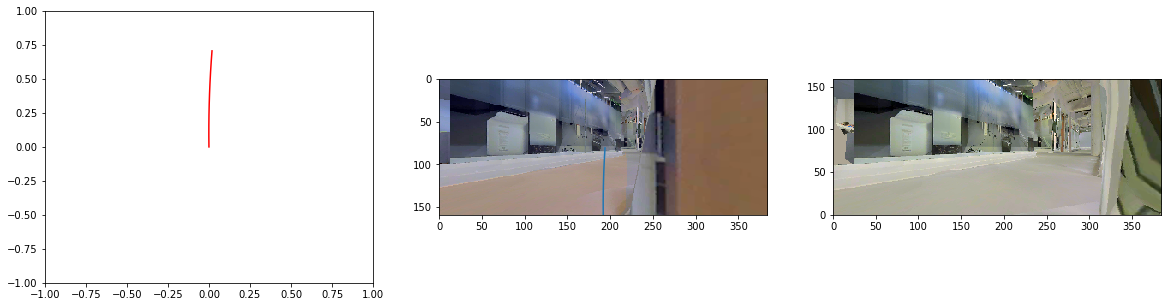

In [988]:
i, j = 30, 15

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,5)); ax[0].set_ylim(-1,1); ax[0].set_xlim(-1,1)
semantic = np.load(Path(f'/Users/nimit/Documents/robomaster/habitat/160x384/semantic/{i+1:03}.npy'))==2

while True:
    arc = get_arc(replay_buffer.actions, i, j) # look up to `i` frames ahead, get `j` movements
    if arc is None:
        break
    x, y = arc
    u, v = world_to_cam(x, y)
    v = 159-torch.clamp(v, min=0, max=159)
    u = torch.clamp(u, min=0, max=383)

    if semantic[int(v[-1])][int(u[-1])]:
#         print(x, y)
#         print(i, j, u, v)
        break
    j -=1

ax[0].plot(x, y, c='r')

ax[1].imshow(replay_buffer.targets[i].squeeze().numpy(), origin='lower')
ax[1].plot(u, v)
ax[1].imshow(semantic, alpha=0.15, cmap='jet', interpolation='none')

ax[2].imshow(replay_buffer.targets[i+j].squeeze().numpy()[::-1], origin='lower')

In [752]:
u, v

(tensor([192.0000, 191.8425, 191.5528, 191.1311, 190.5776, 189.8925, 189.0763,
         188.1292, 187.0517, 185.8442]),
 tensor([159.0000, 154.5207, 150.0470, 145.5818, 141.1282, 136.6889, 132.2669,
         127.8651, 123.4864, 119.1337]))

# Position

In [1294]:
from buffer.dataset import HabitatDataset
from pathlib import Path
from pyquaternion import Quaternion
d = HabitatDataset(Path('/Users/nimit/Documents/robomaster/habitat/005053'), 'semantic', None)#'apartment_02')

def rotate_origin_only(x, y, radians):
    """Only rotate a point around the origin (0, 0)."""
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

In [1387]:
t = np.array([Quaternion(*d.rotations[i, 1:4], d.rotations[i, 0]).yaw_pitch_roll[1] for i in range(20)])

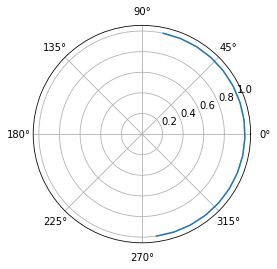

In [1389]:
plt.polar(t, np.ones(t.shape[0]))

(-3, 3)

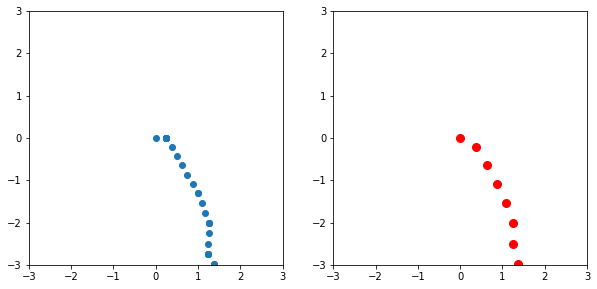

In [1416]:
i = 20; zoom = 3
semantic = d.target_f[:]
x, y, z = d.positions.T

xy = np.stack([x, -z], axis=-1)
path = xy[i:] - xy[i]
path = np.stack(rotate_origin_only(*path.T, Quaternion(*d.rotations[i, 1:4], d.rotations[i, 0]).yaw_pitch_roll[1] + np.pi/2), axis=-1)

valid = np.any((path > zoom) | (path < -zoom), axis=1)
first_invalid = np.searchsorted(np.cumsum(valid), 1)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
ax[0].scatter(*path.T)
ax[0].set_xlim(-zoom, zoom)
ax[0].set_ylim(-zoom, zoom)
ax[0].set_aspect('equal', adjustable='box')

# sample uniformly
x,y = path[:first_invalid].T
xd = np.diff(x)
yd = np.diff(y)
dist = np.sqrt(xd**2+yd**2)
u = np.cumsum(dist)
u = np.hstack([[0],u])

t = np.linspace(0,u.max(), 8)
xn = np.interp(t, u, x)
yn = np.interp(t, u, y)

ax[1].set_aspect('equal')
# ax.plot(x,y,'o', alpha=0.3)
ax[1].plot(xn,yn,'ro', markersize=8)
ax[1].set_xlim(-zoom,zoom)
ax[1].set_ylim(-zoom,zoom)

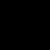

In [1414]:
Image.new(size=(50,50), mode='L')

### Sampling Original Path

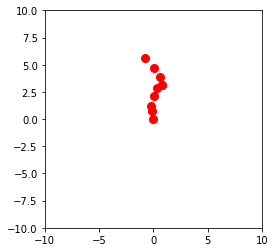

In [1323]:
from math import ceil, floor
def takespread(sequence, num):
    length = float(len(sequence))
    for i in range(num):
        yield sequence[int(ceil(i * length / num))]

plt.scatter(*np.array(list(takespread(path[:first_invalid], 10))).T, c='r', s=64)
plt.xlim(-zoom, zoom)
plt.ylim(-zoom, zoom)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

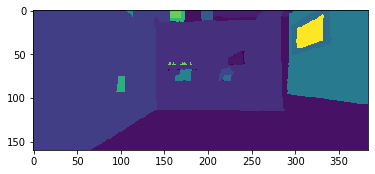

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [1035]:
img = None
for s in semantic:
    if img is None:
        img = plt.imshow(s.squeeze())
    else:
        img.set_data(s.squeeze())
    plt.pause(.1)
    plt.draw()